In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/'
stispath = '{}stis/'.format(path)
cospath = '{}cos/'.format(path)

In [3]:
x1ds = np.hstack((glob.glob('{}*0_x1d.fits'.format(stispath)), glob.glob('{}*sx1.fits'.format(stispath))))#, glob.glob('{}*x1dsum.fits'.format(path))))
x1ds


array(['/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03030_sx1.fits'],
      dtype='<U70')

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03010_x1d.fits
G140M
[173.27858]


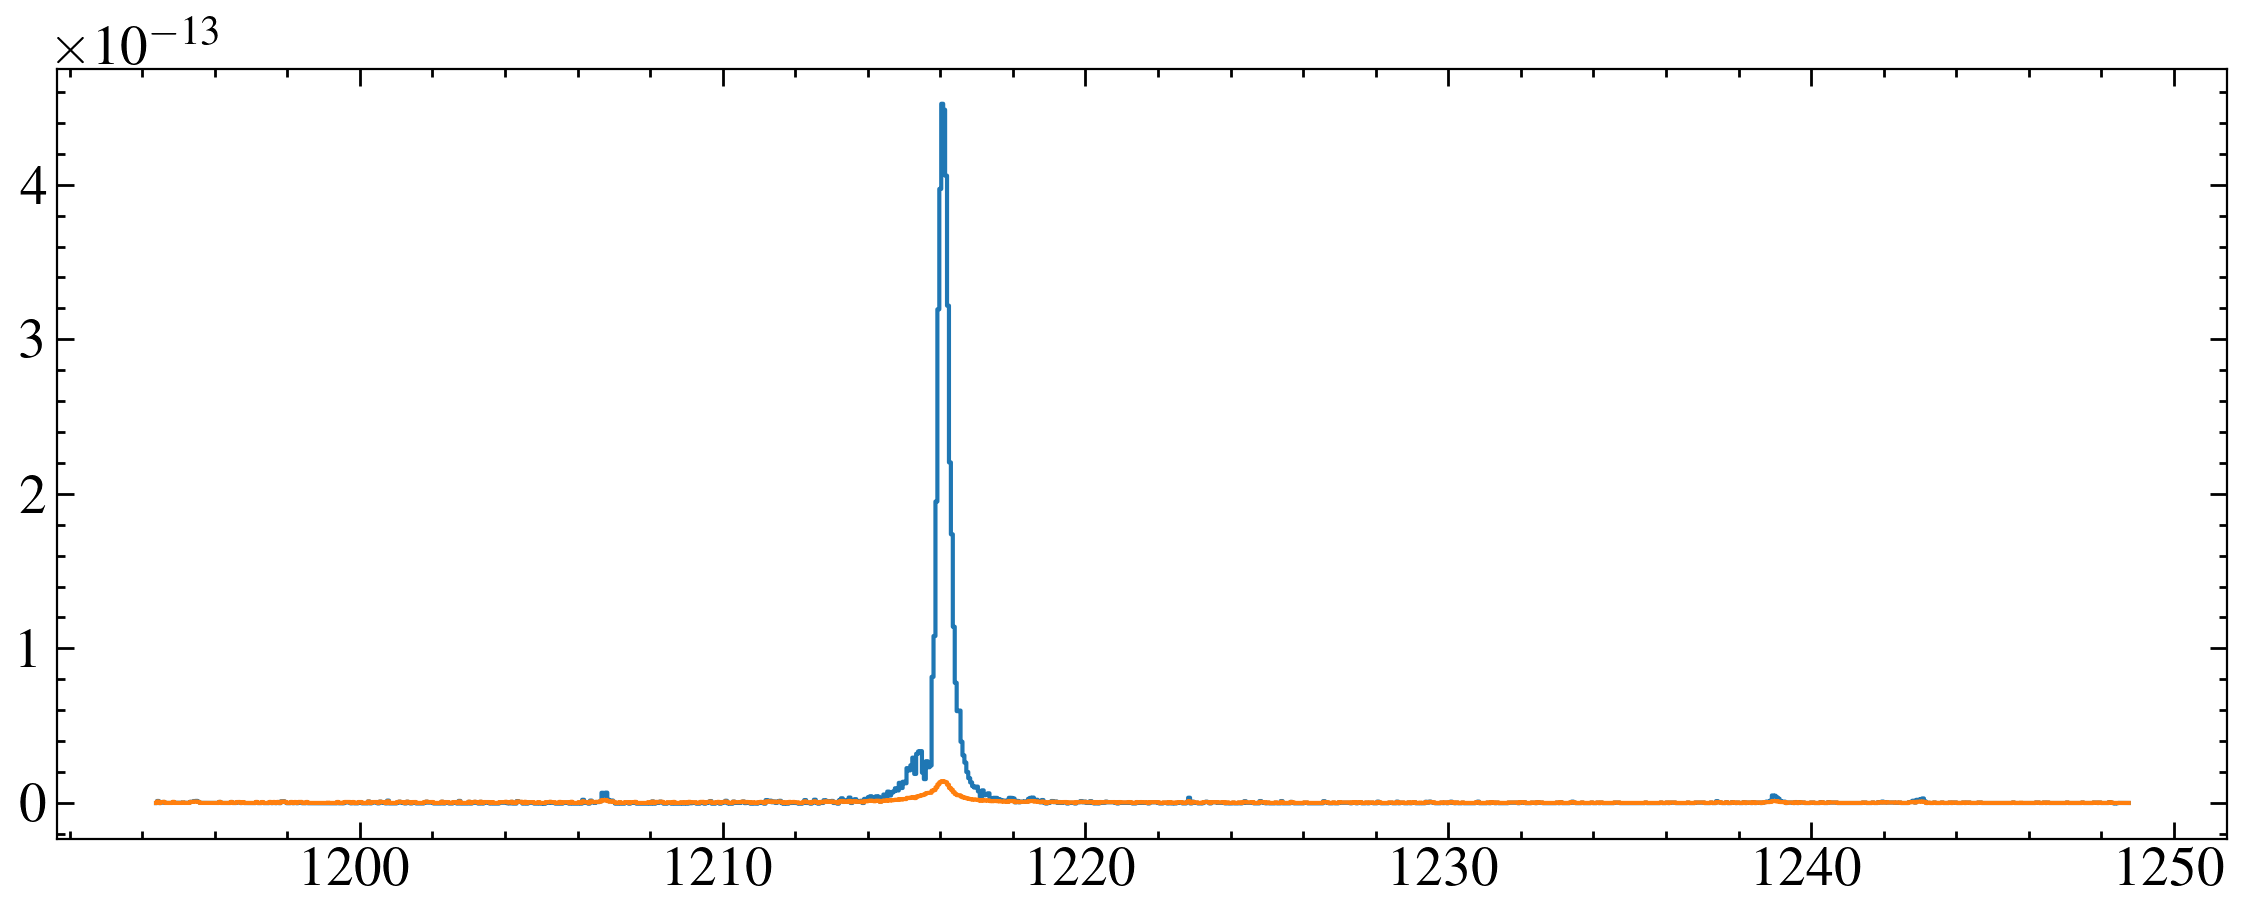

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03020_x1d.fits
G230L
[528.51666]


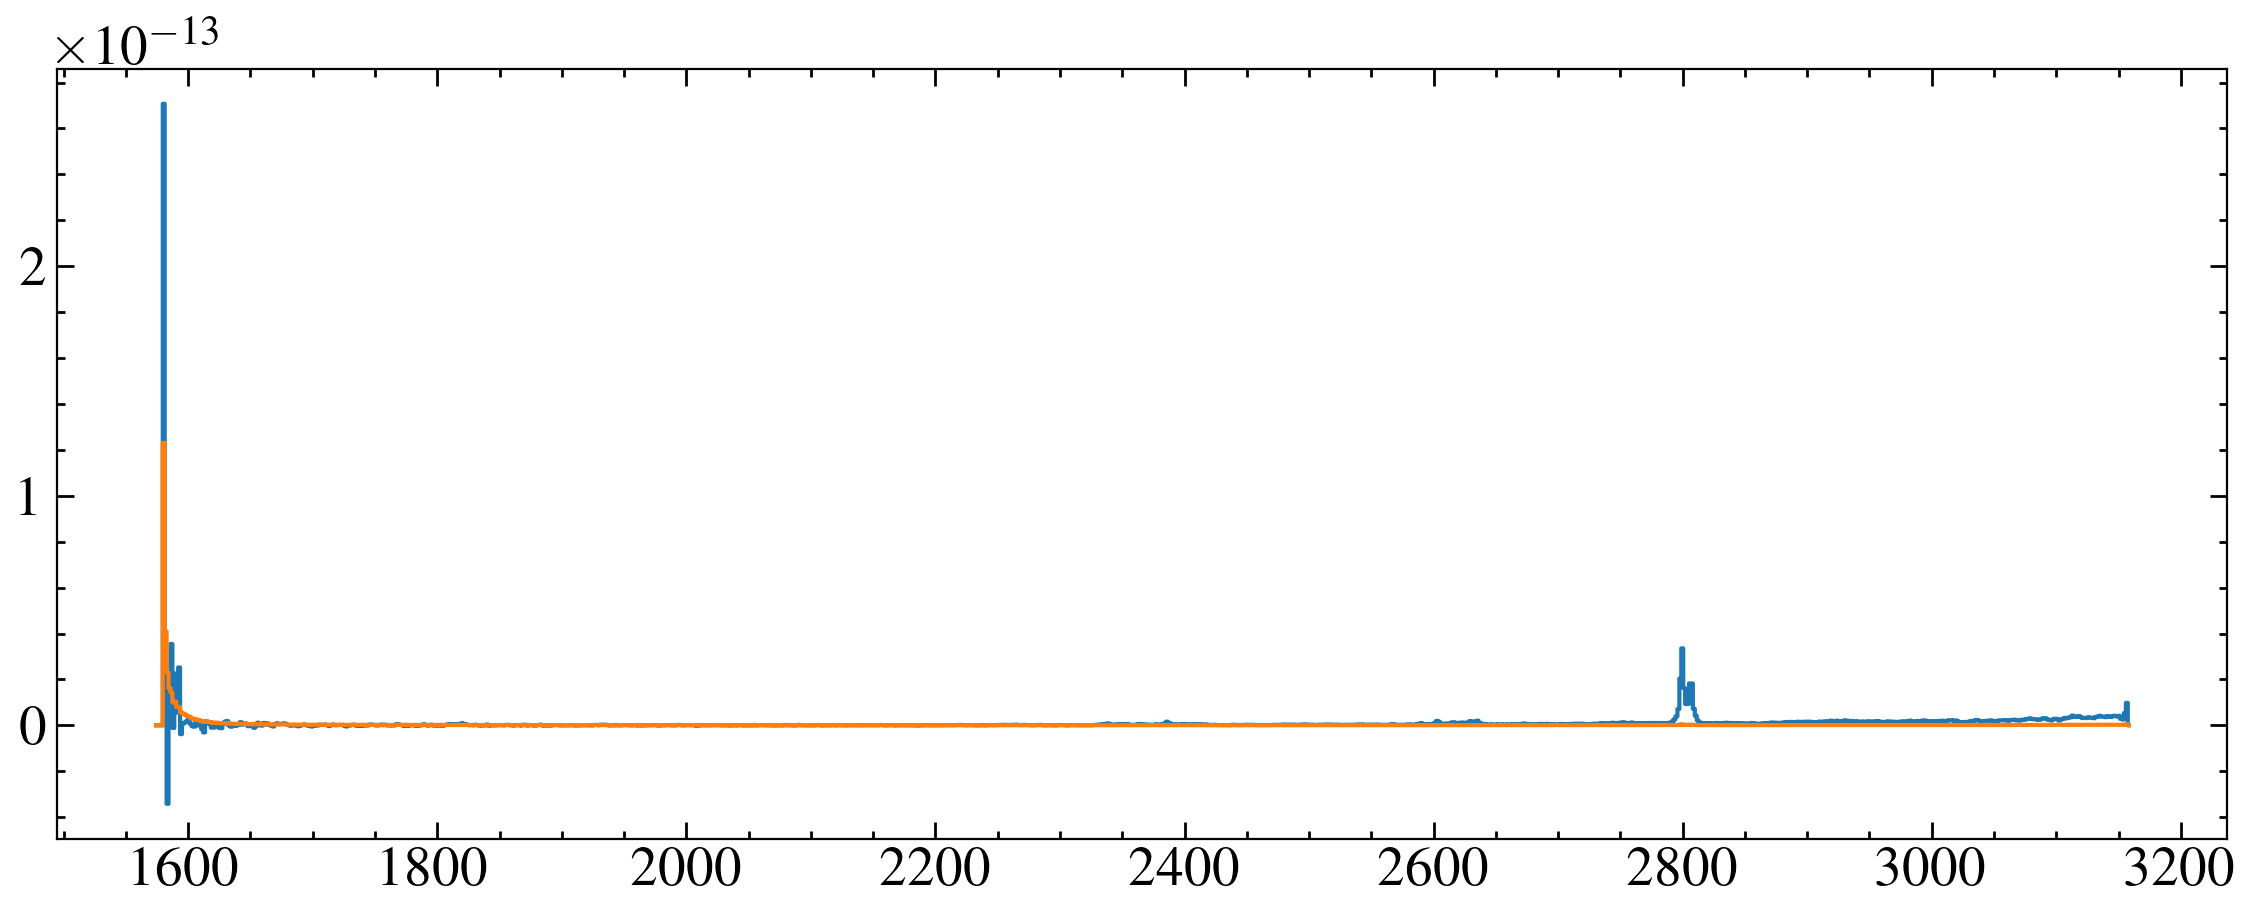

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03030_sx1.fits
G430L
[894.6452]


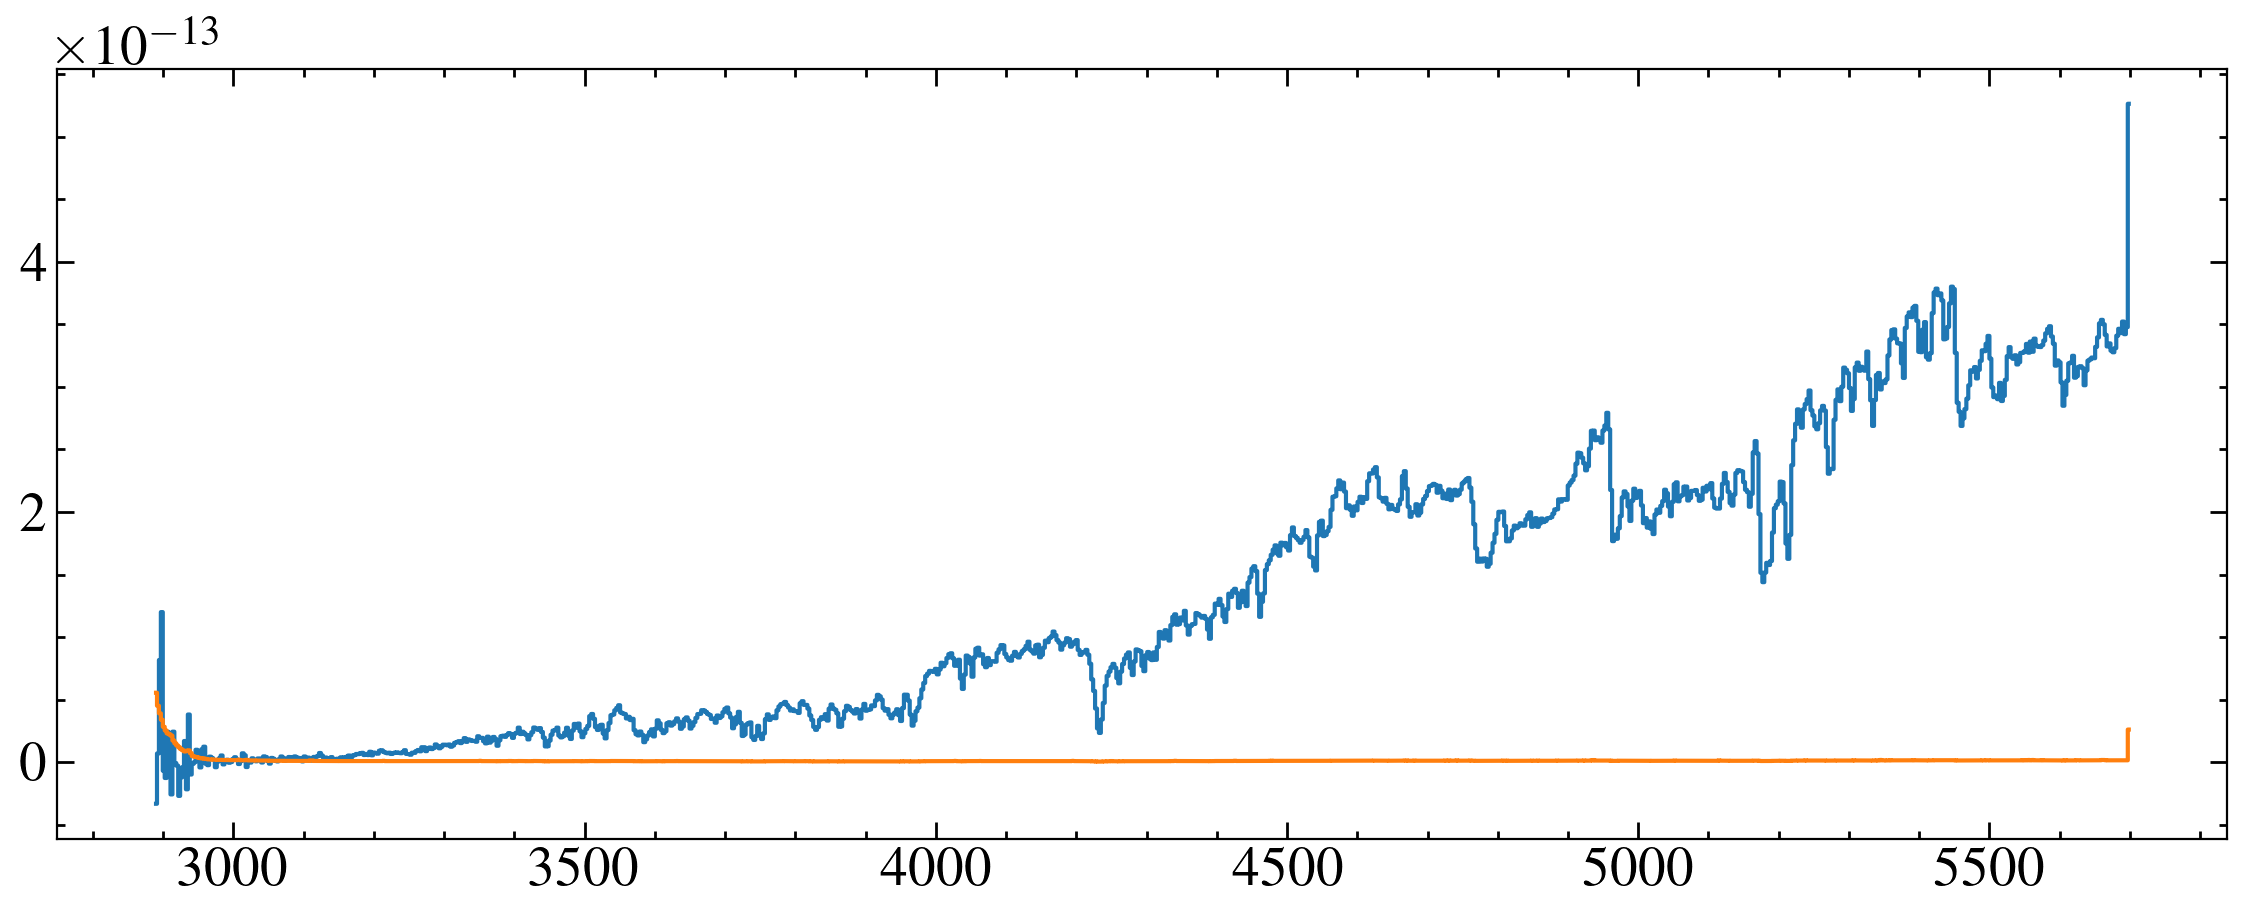

In [4]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.show()

    

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03010_x1d.fits
G140M
173.27858
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03020_x1d.fits
G230L
528.51666
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03030_sx1.fits
G430L
894.6452


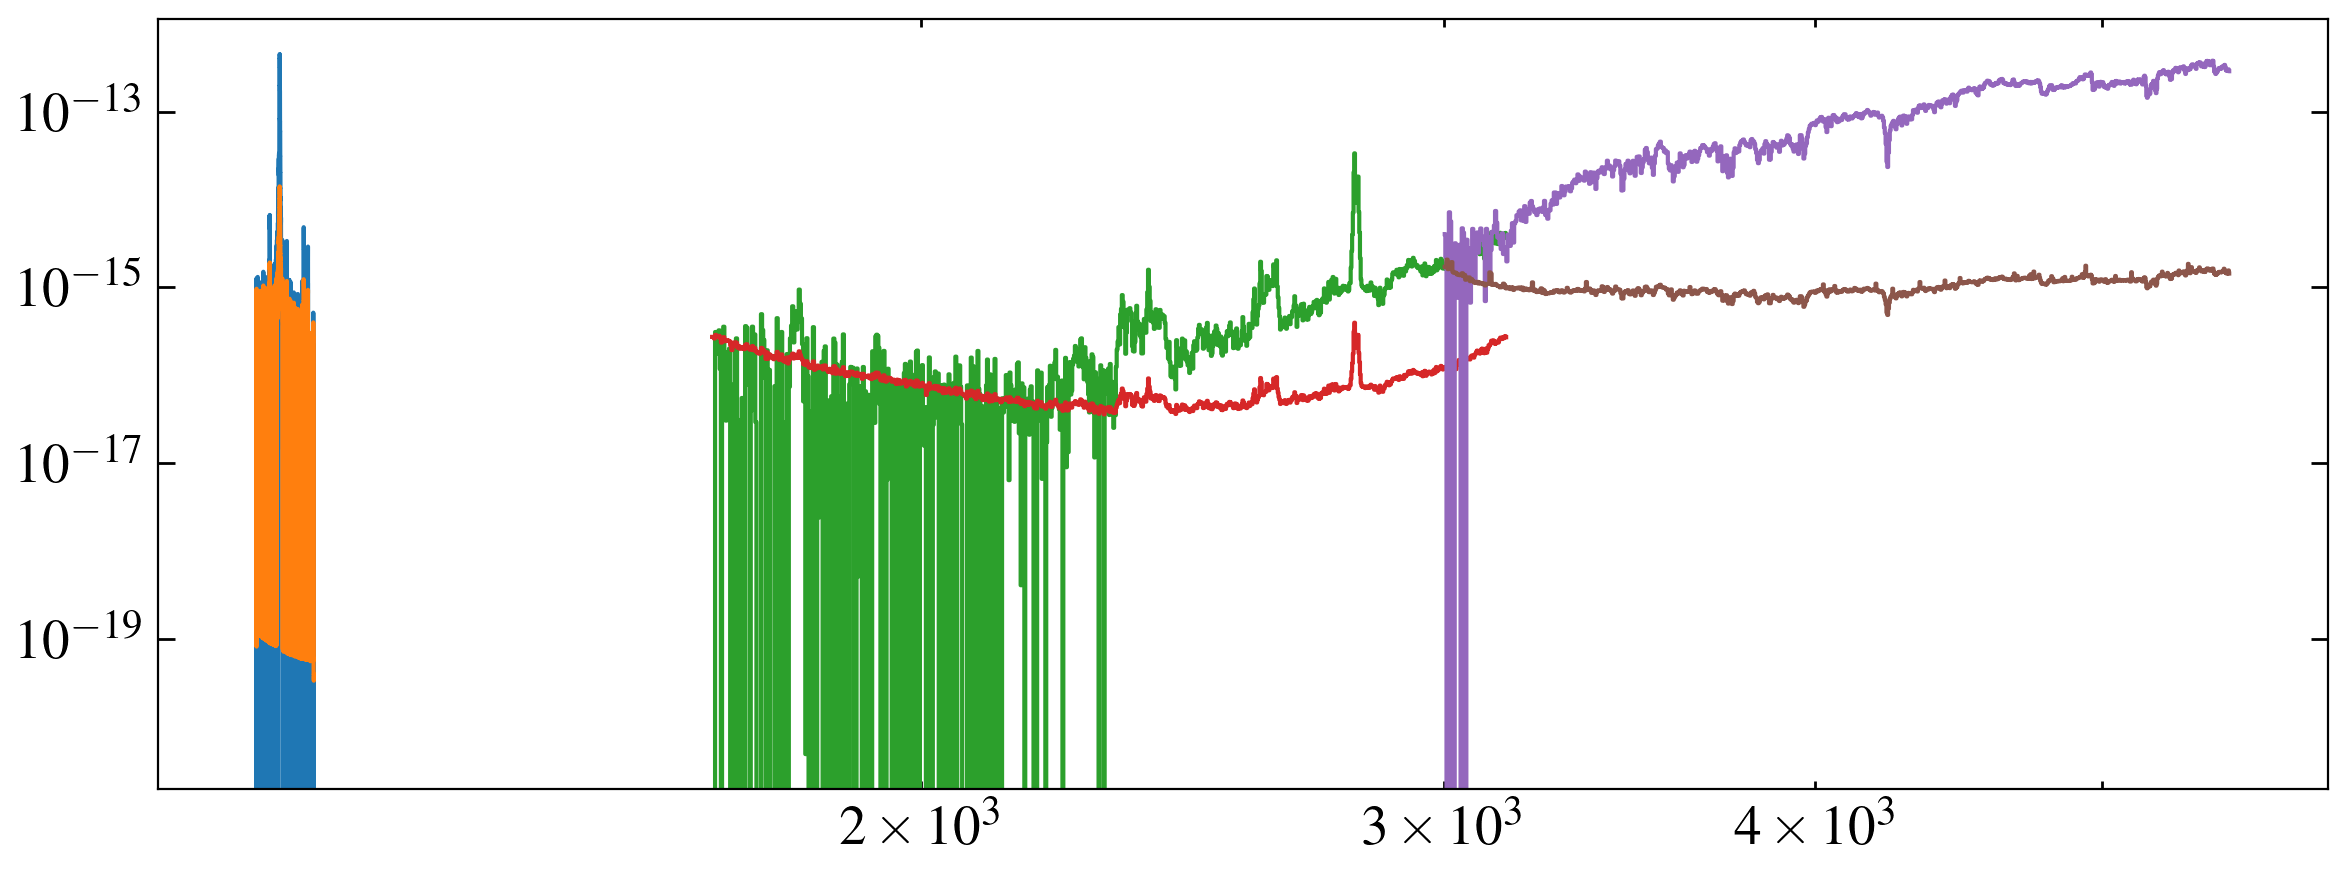

In [5]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
#     plt.show()
    
plt.yscale('log')
plt.xscale('log')

STIS all looks good. Rest of the data is COS - need to update prepare_cos for Meats

In [6]:
import importlib
import prepare_stis
importlib.reload(prepare_stis)

<module 'prepare_stis' from '/home/david/work/meats/SEDs/prepare_stis.py'>

/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/astropy/stats/funcs.py:702: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]


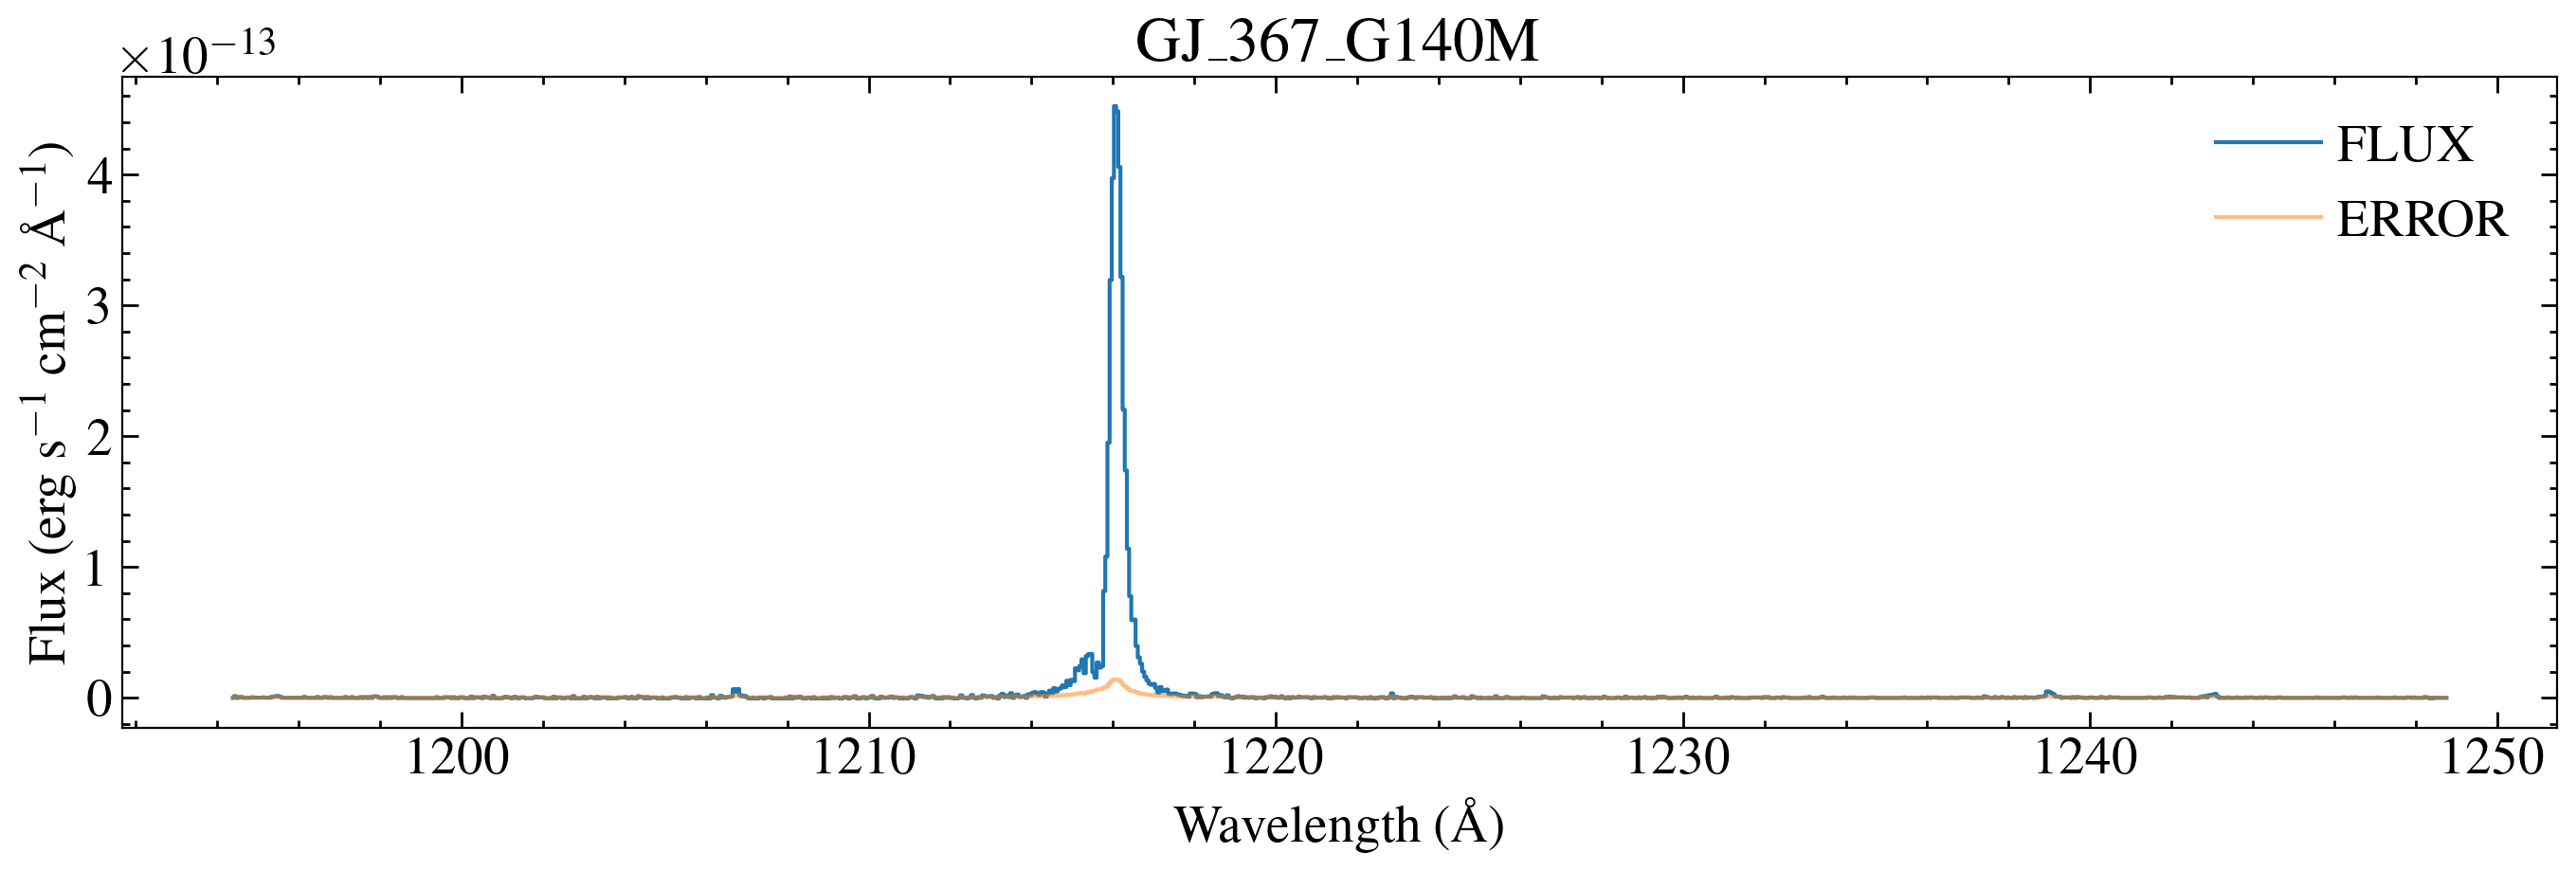

Spectrum saved as hlsp_muscles_hst_stis_gj_367_g140m_v1_component-spec.fits


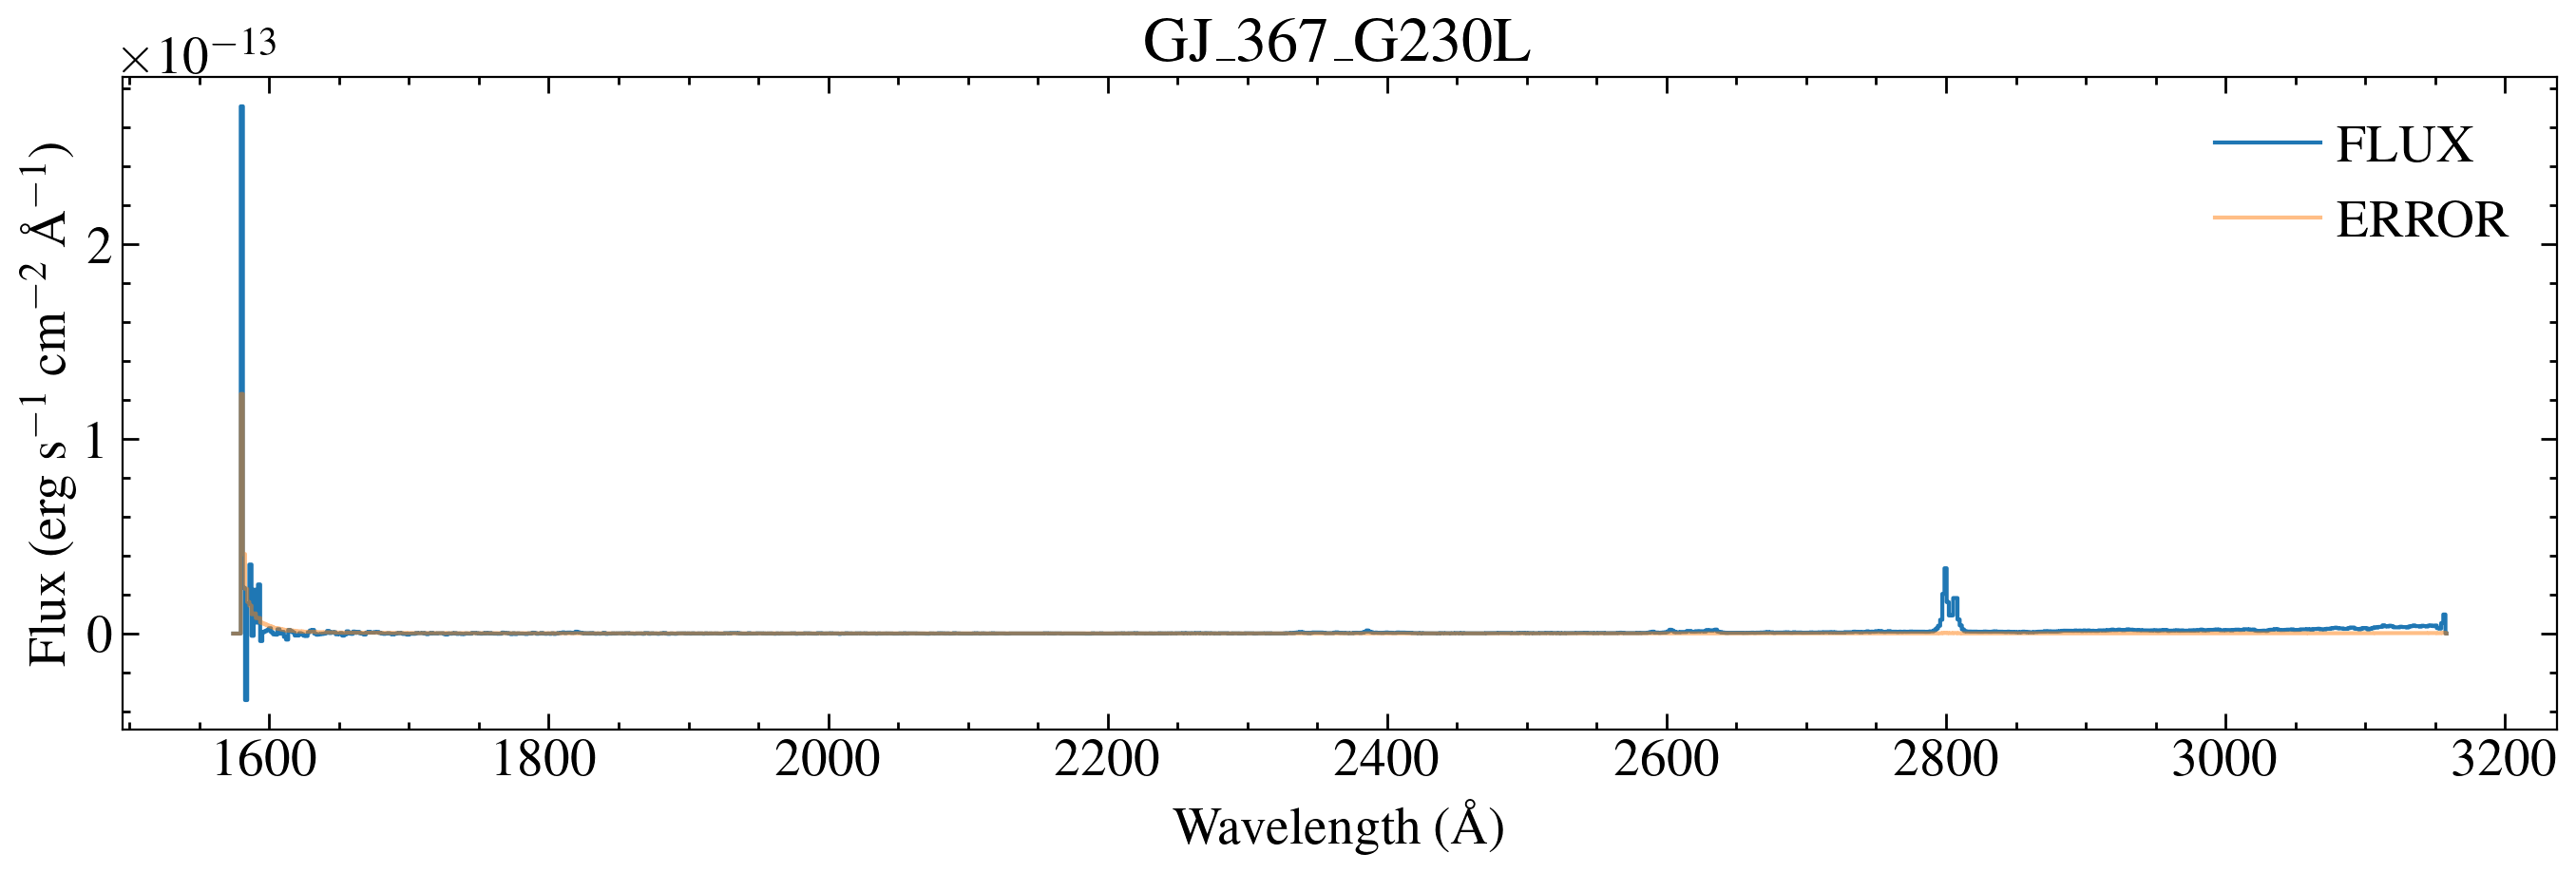

Spectrum saved as hlsp_muscles_hst_stis_gj_367_g230l_v1_component-spec.fits


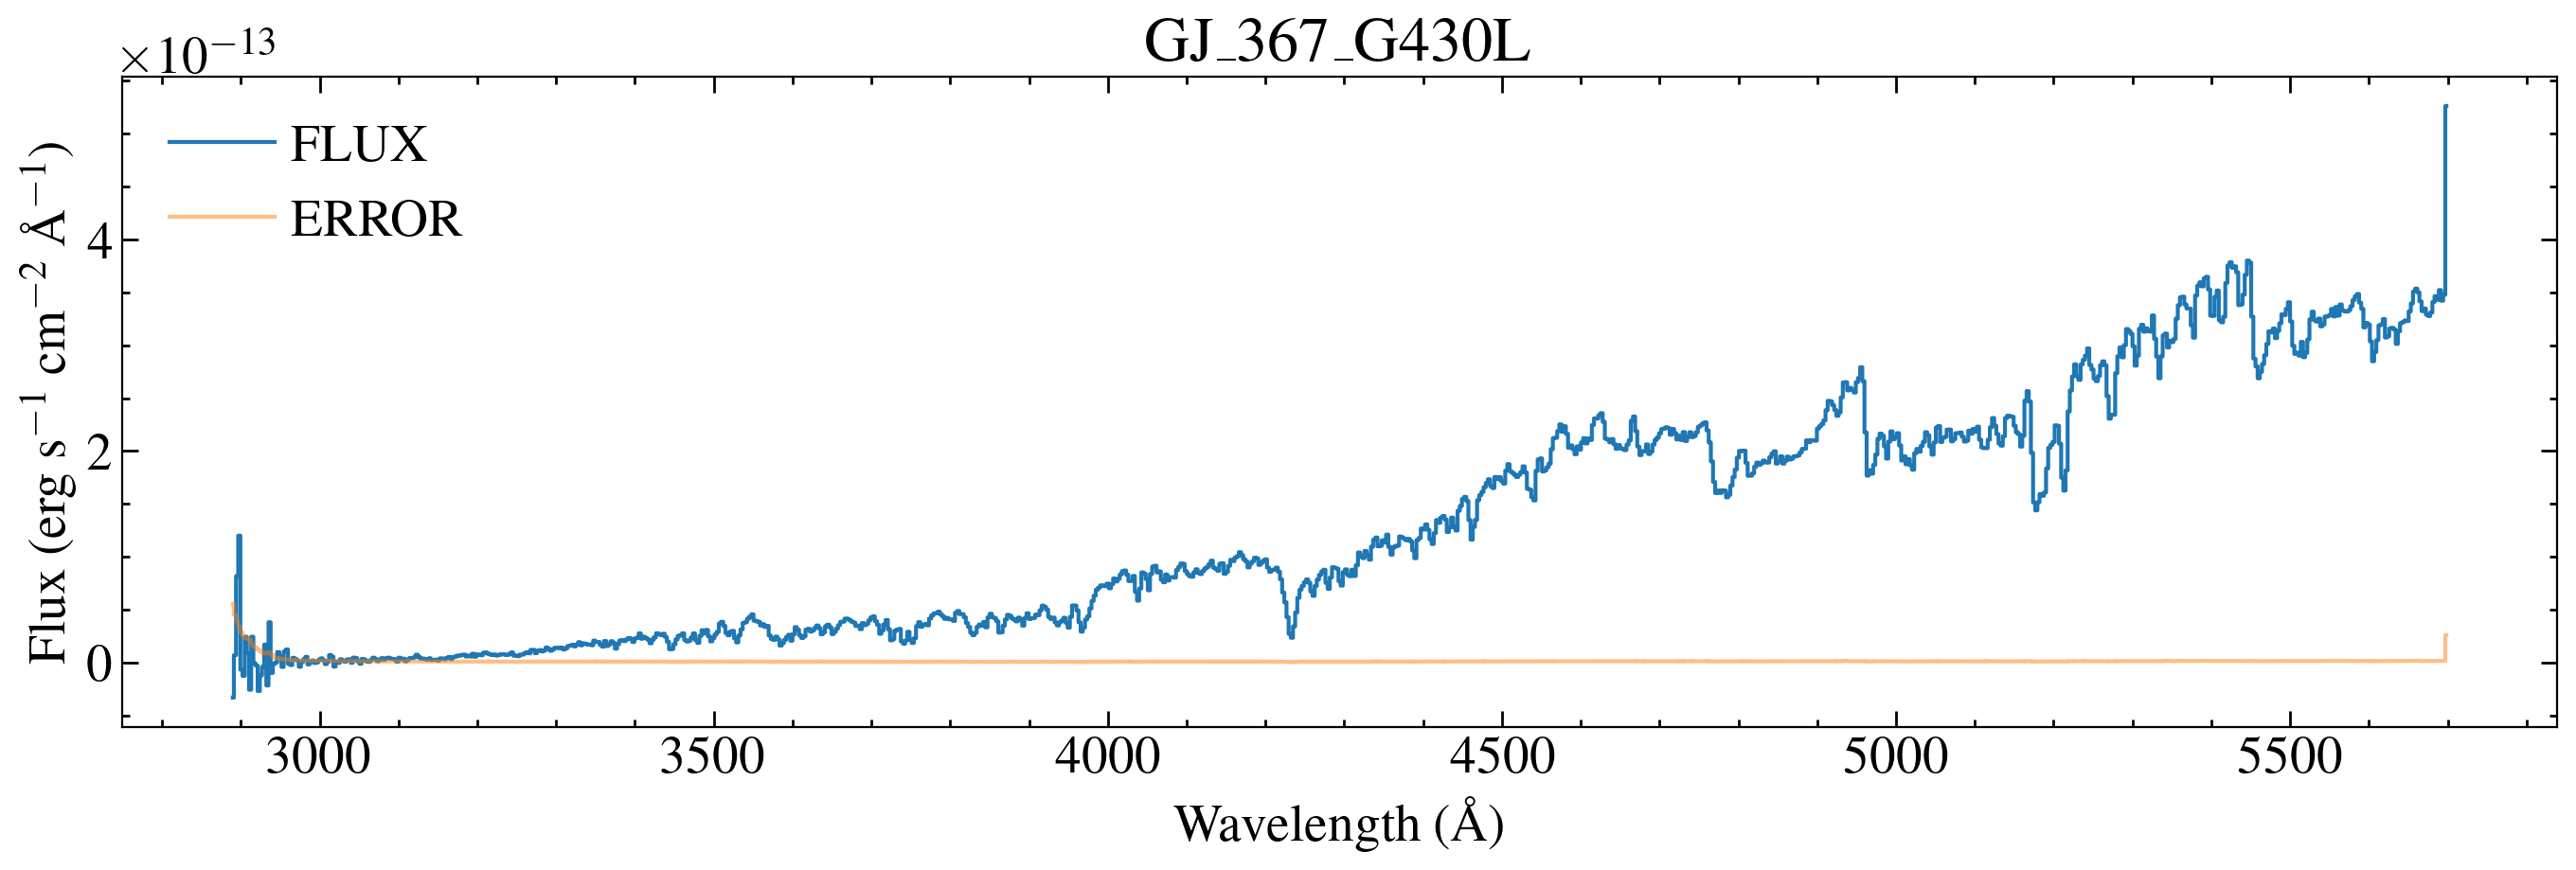

Spectrum saved as hlsp_muscles_hst_stis_gj_367_g430l_v1_component-spec.fits


In [7]:
x1dpath = stispath
savepath = 'draft_hlsp/gj_367/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'GJ_367')

In [8]:
import prepare_phoenix_svo as pp
importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.454
teff = 3522
teff_e = 70

radius = 0.457
distance = 9.42

save_path = 'models/'
star = 'GJ_367'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.777
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [9]:
hlsp_x1ds = glob.glob('draft_hlsp/gj_367/*stis*.fits')
hlsp_x1ds

['draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g430l_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g140m_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g230l_v1_component-spec.fits']

draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g140m_v1_component-spec.fits
draft_hlsp/gj_367/hlsp_muscles_hst_stis_gj_367_g230l_v1_component-spec.fits


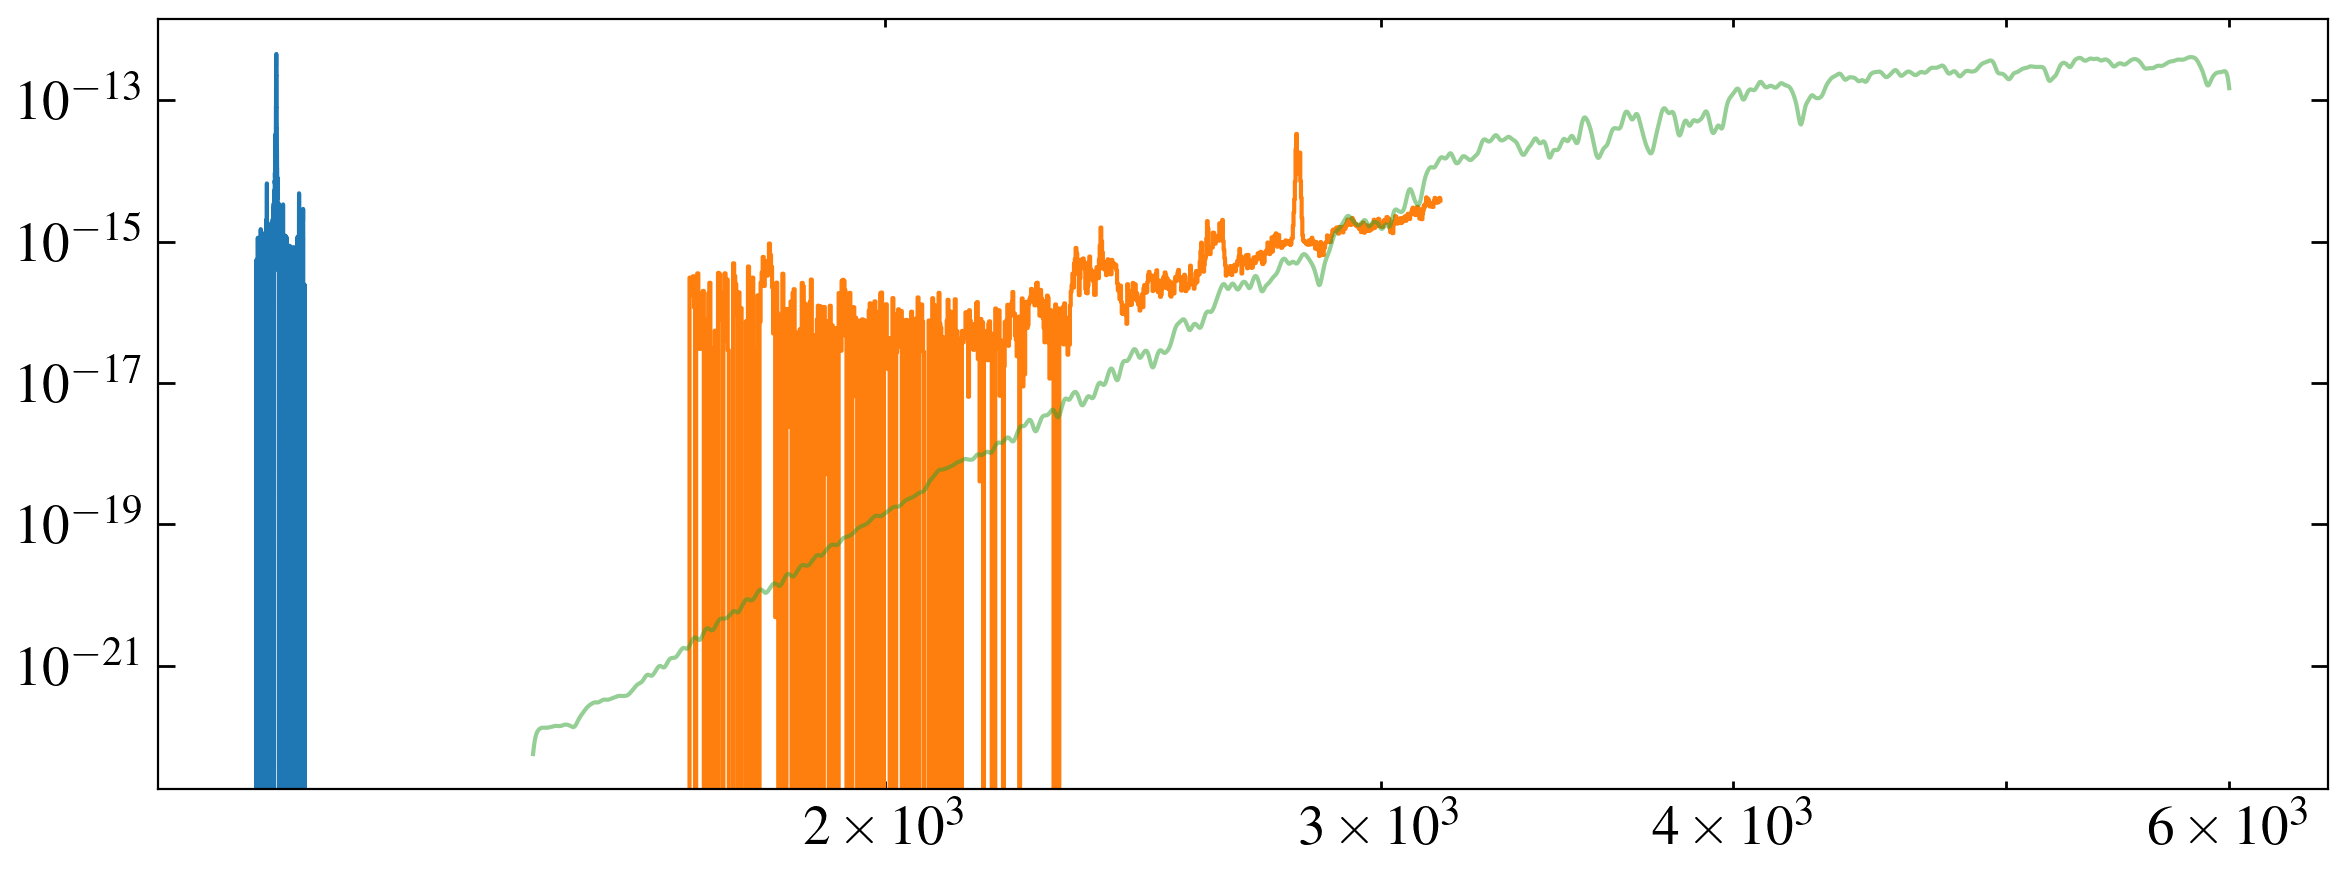

In [10]:
for x in hlsp_x1ds[1:]:
    print(x)
    grating = fits.getheader(x, 0)['GRATING'] 
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if grating in ['G140M', 'G140L']:
#         mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
#     plt.step(w, e, where='mid')
#     plt.show()
   
pmask = (pw > 1500) & (pw < 6000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi,500)
plt.plot(pwi, pfi, alpha=0.5)
    
plt.yscale('log')
plt.xscale('log')

Can live with that given the opacity problem. Kevin has made the data into a txt file, may need to re-write prepare cos...

In [11]:
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/cos/leoo04010_x1dsum.fits'
xdata = fits.getdata(x1dpath, 1)

cdata = Table.read('cos_files/gj367/GJ367_COS130M_NoSCL_Mm1_17aug2023.txt', format='ascii.basic')

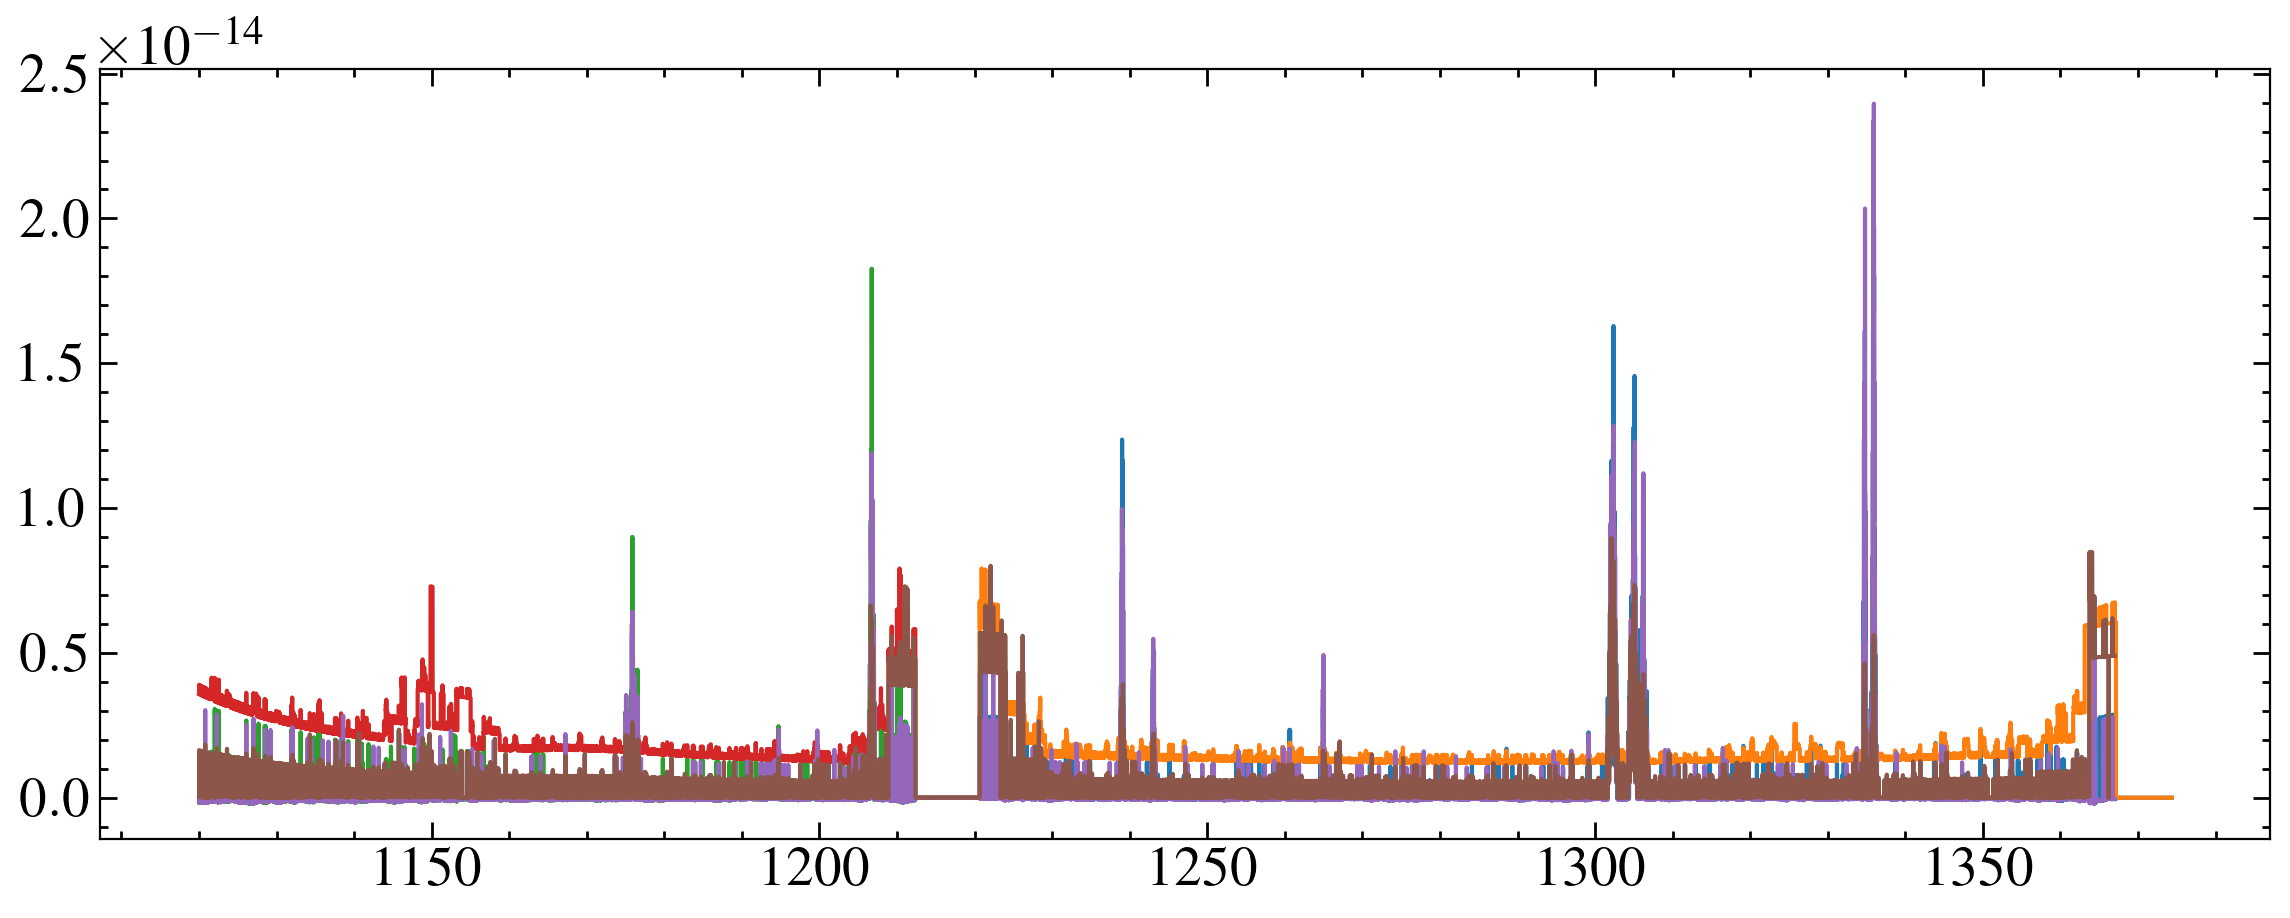

In [12]:
for dt in xdata:
    mask = dt['WAVELENGTH'] > 1120

    plt.step(dt['WAVELENGTH'][mask], dt['FLUX'][mask], where='mid')
    plt.step(dt['WAVELENGTH'][mask], dt['ERROR'][mask], where='mid')

mask = cdata['WAVELENGTH'] > 1120
plt.step(cdata['WAVELENGTH'][mask], cdata['FLUX'][mask], where='mid')
plt.step(cdata['WAVELENGTH'][mask], cdata['ERROR'][mask], where='mid')

In [13]:
xdata['WAVELENGTH']

array([[1211.12701601, 1211.13697905, 1211.14694209, ..., 1374.33157688,
        1374.34153992, 1374.35150296],
       [1058.11852785, 1058.12847907, 1058.13843029, ..., 1221.12944841,
        1221.13939963, 1221.14935084]], dtype='>f8')

In [14]:
np.hstack(xdata['WAVELENGTH'])

array([1211.12701601, 1211.13697905, 1211.14694209, ..., 1221.12944841,
       1221.13939963, 1221.14935084])

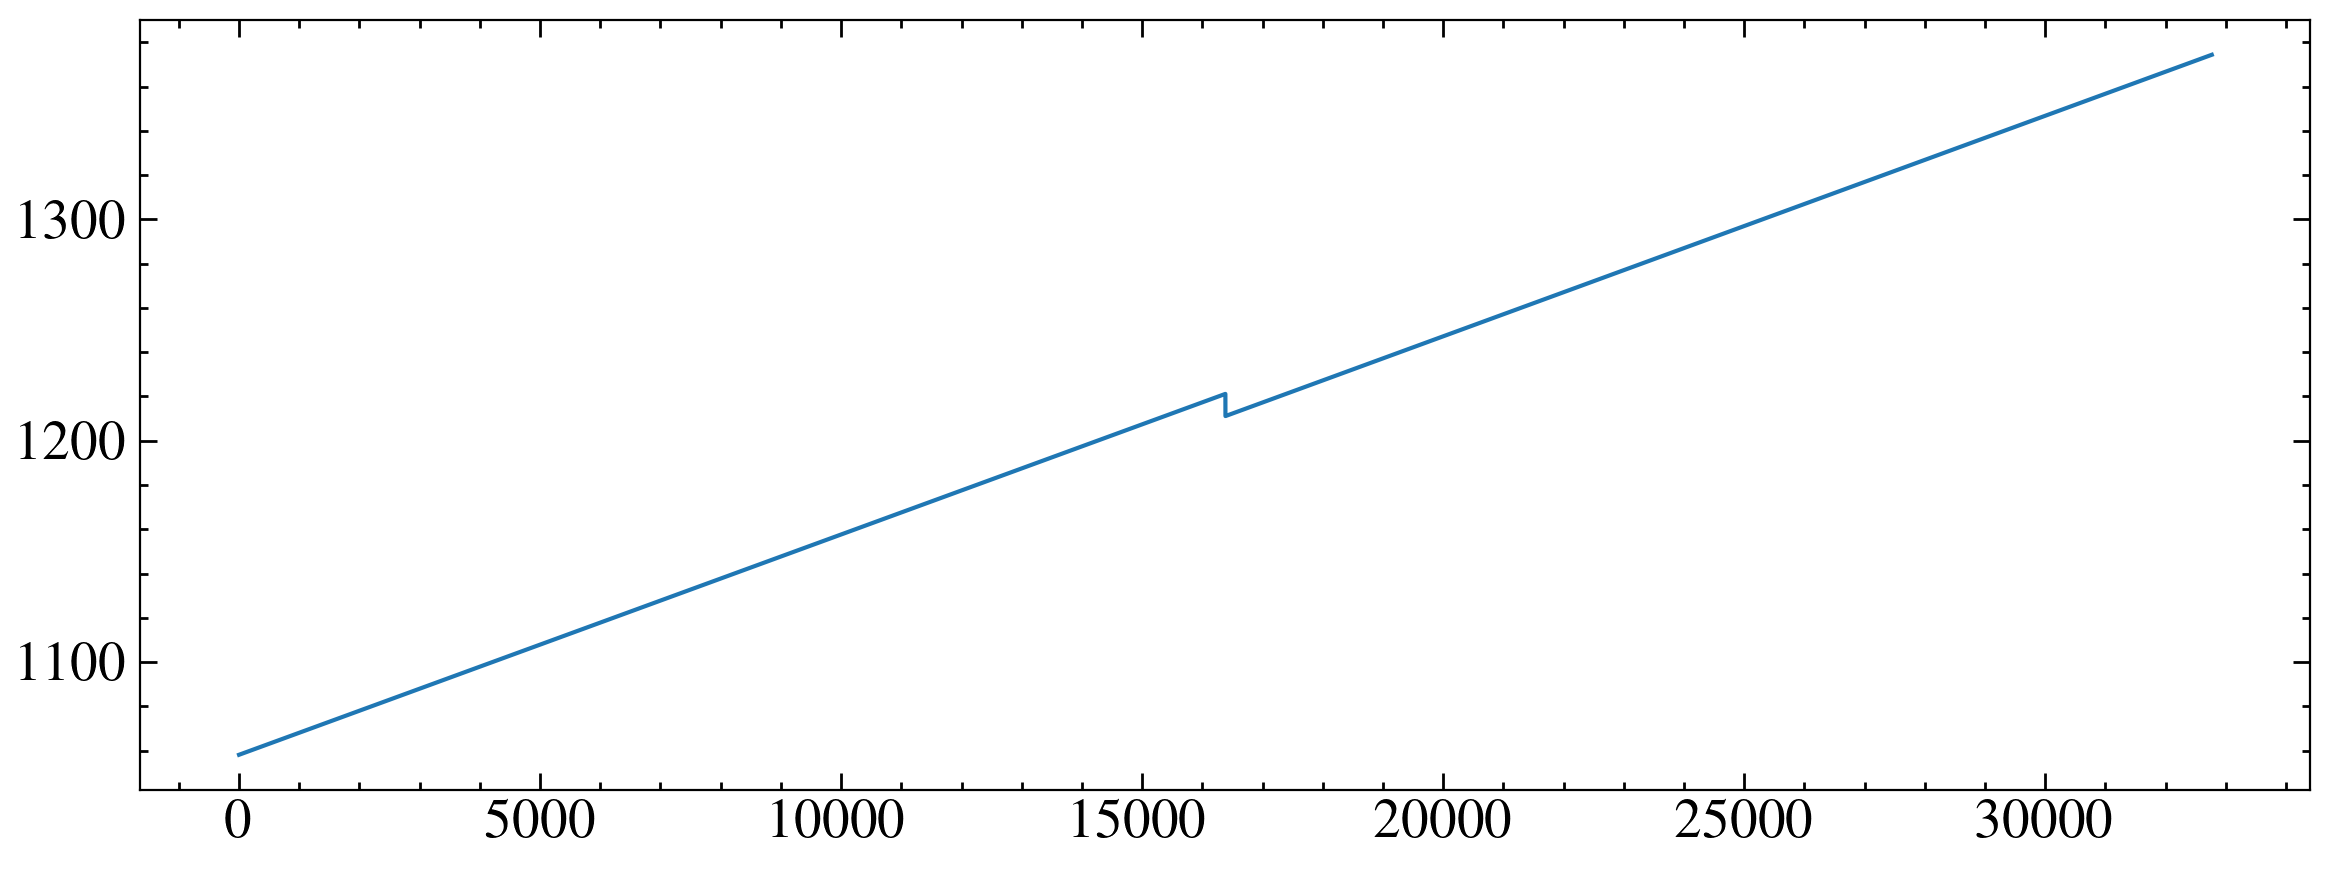

In [15]:
# plt.plot(np.hstack(xdata['WAVELENGTH'][::-1]), np.hstack(xdata['FLUX'][::-1]))
plt.plot(np.arange(len(np.hstack(xdata['WAVELENGTH']))), np.hstack(xdata['WAVELENGTH'][::-1]))

30291 30291 30291 30291
['/media/david/2tb_ext_hd/hddata/meats/hst/gj367/cos/leoo04010_x1dsum.fits']


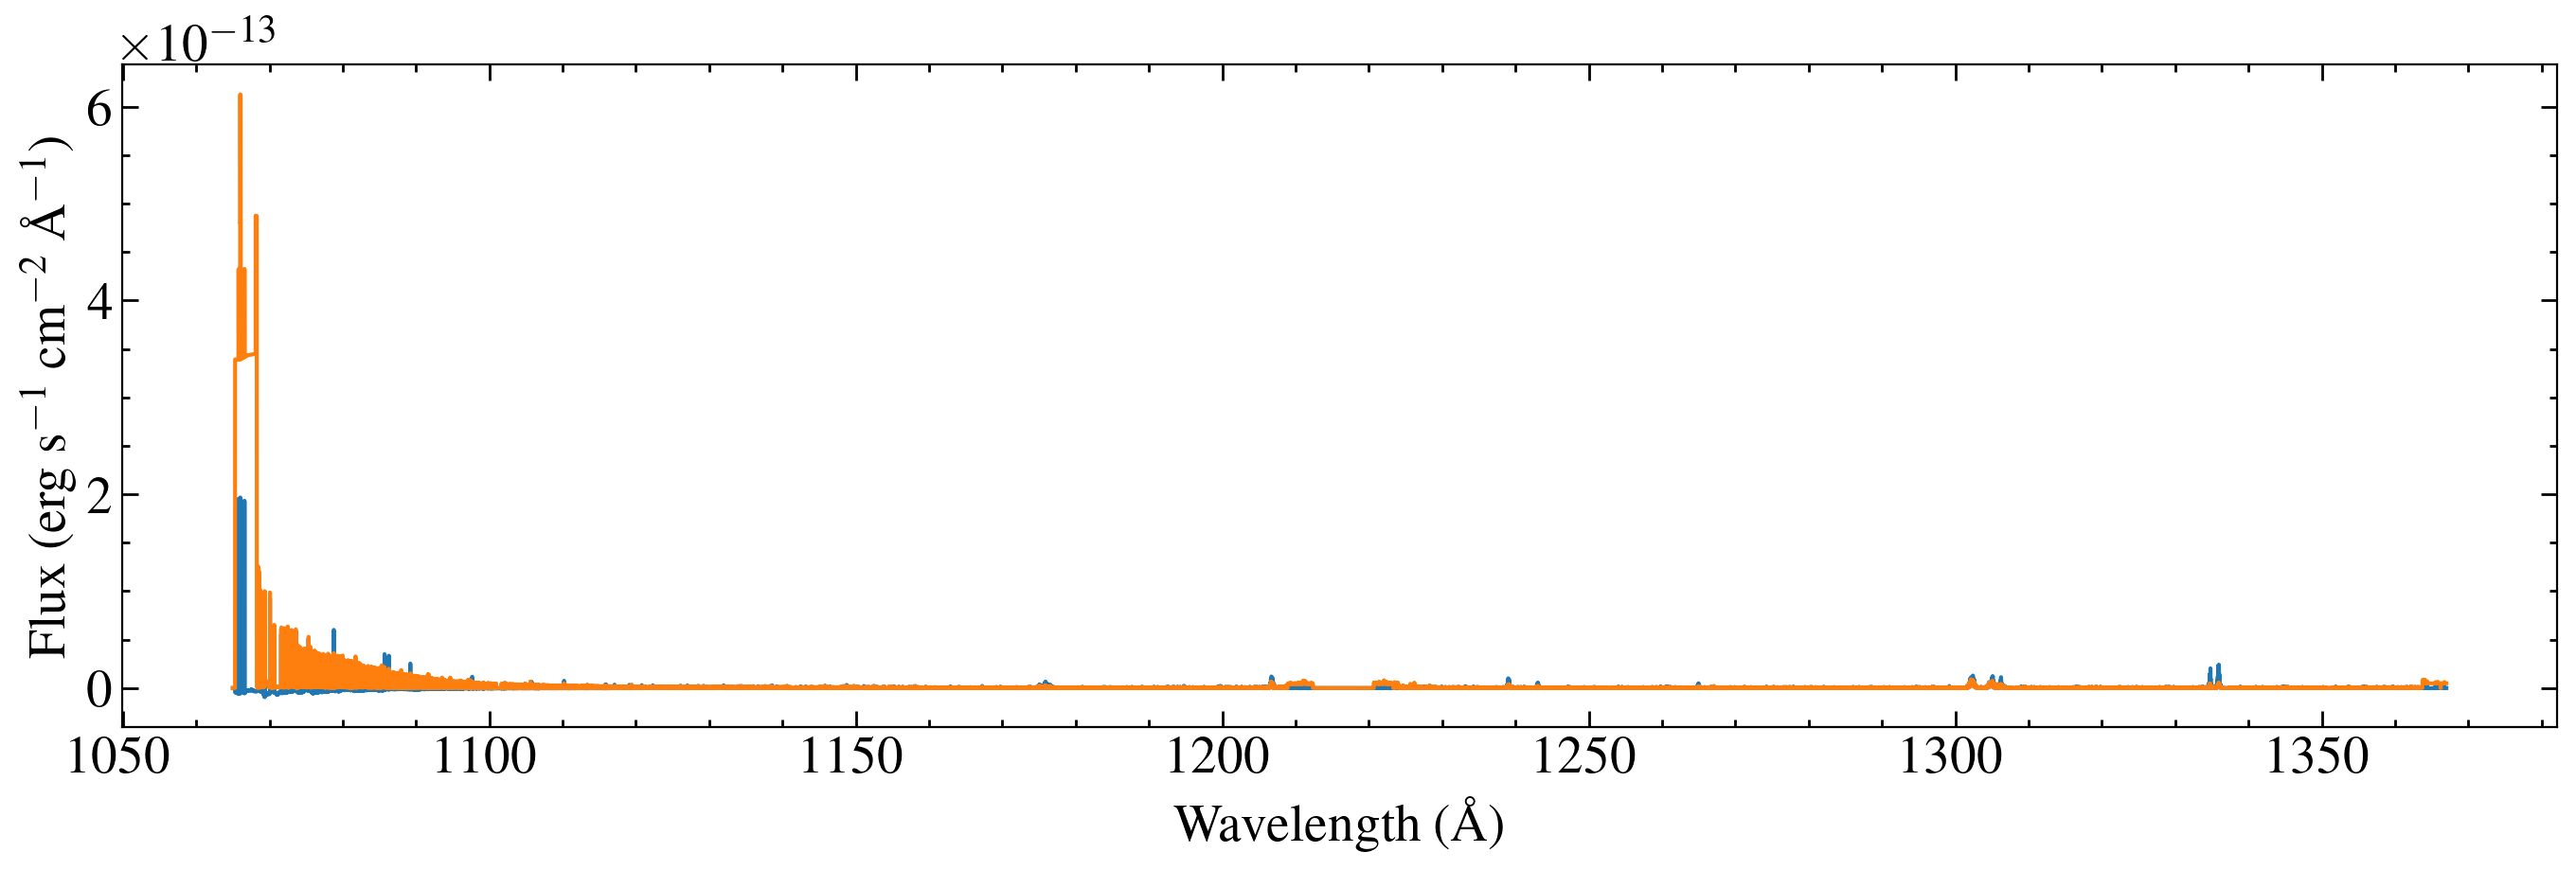

Spectrum saved as hlsp_muscles_hst_cos_gj_367_g130m_v1_component-spec.fits


In [16]:
import prepare_cos
importlib.reload(prepare_cos)

savpath = 'cos_files/gj367/GJ367_COS130M_NoSCL_Mm1_17aug2023.txt'
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/cos/'
hlsp = 'meats_hlsp_info.csv'
version = 1
savepath = 'draft_hlsp/gj_367/'
# star = 
prepare_cos.make_cos_spectrum(savpath, version, x1dpath, hlsp, savepath = savepath, plot=True, save_fits=True, star='GJ_367')

In [17]:
# hdr = fits.getheader('{}leoo04010_x1dsum.fits'.format(x1dpath), 0)
# hdr

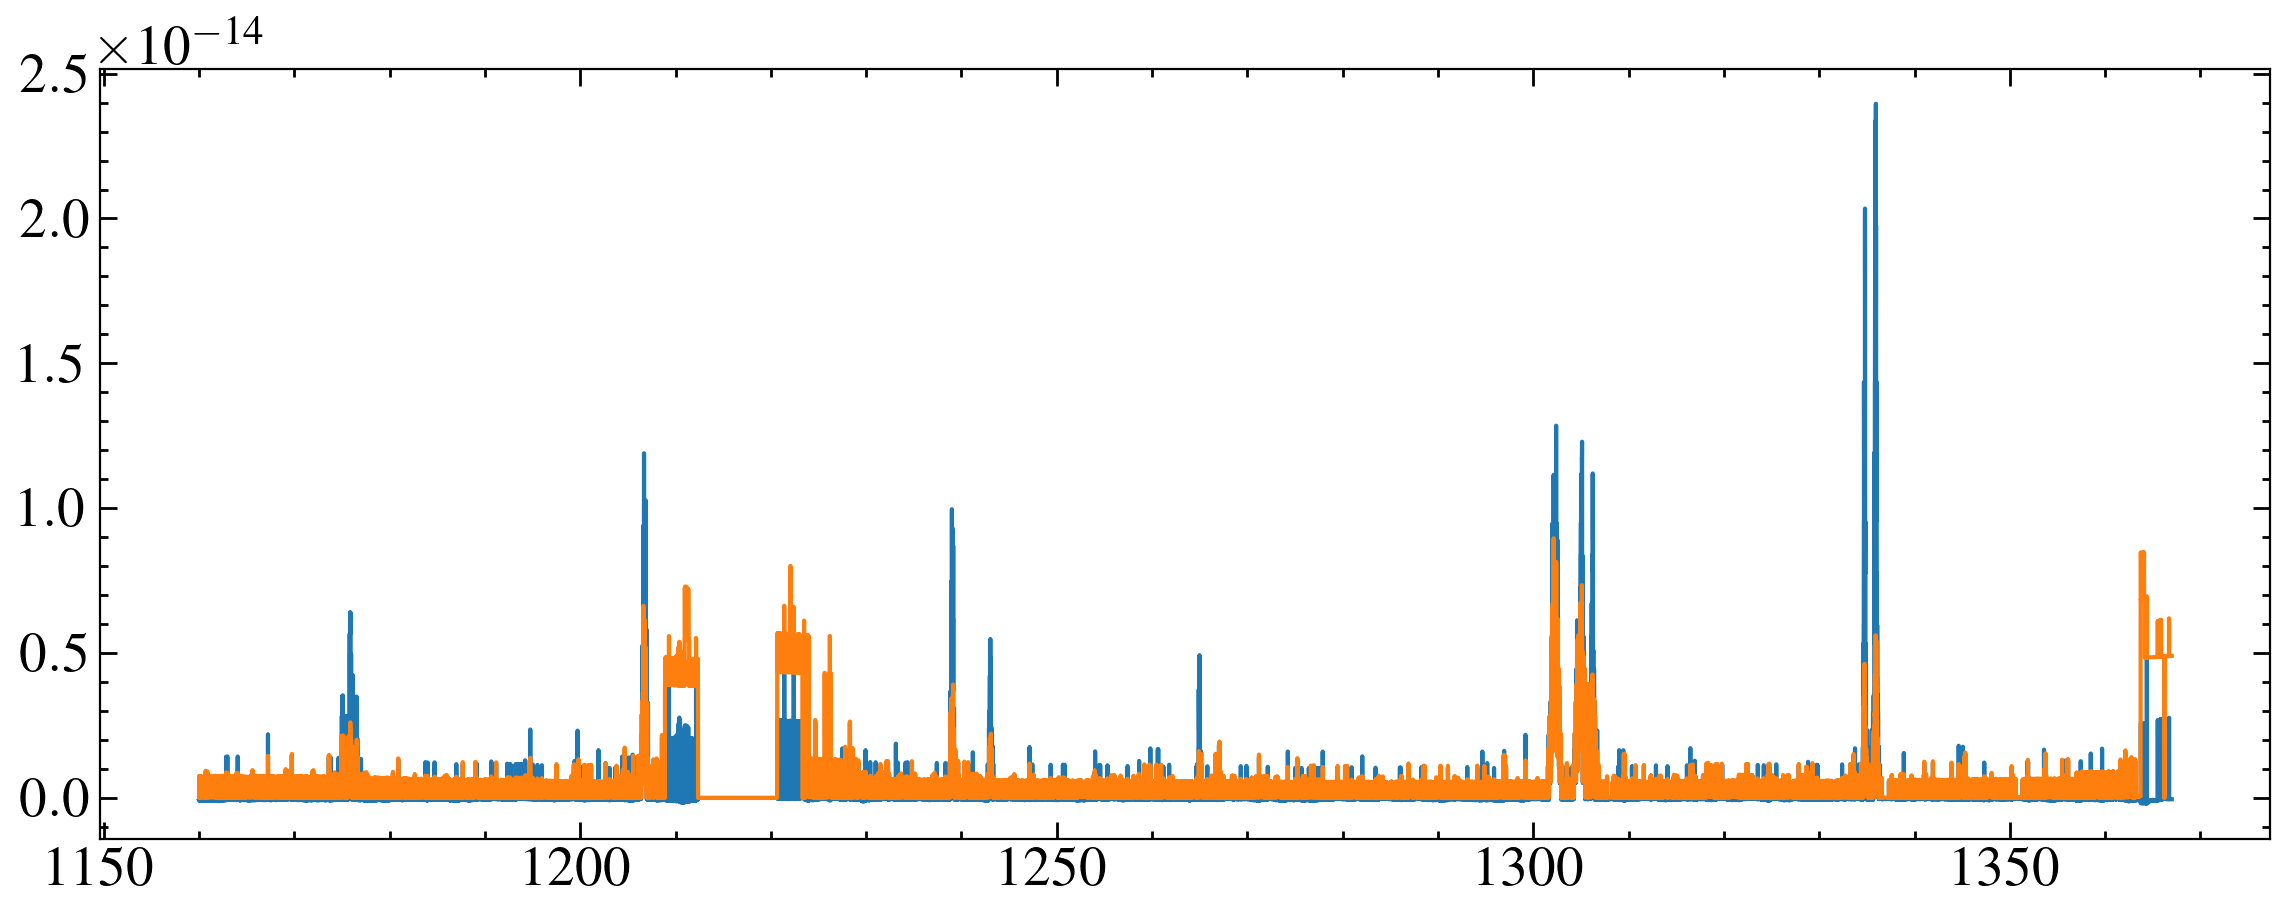

In [18]:
data = fits.getdata('draft_hlsp/gj_367/hlsp_muscles_hst_cos_gj_367_g130m_v1_component-spec.fits', 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1160
w, f, e = w[mask], f[mask], e[mask]
plt.step(w, f, where='mid', c='C0')
plt.step(w, e, where='mid', c='C1')

Light cuves

662759008.9181


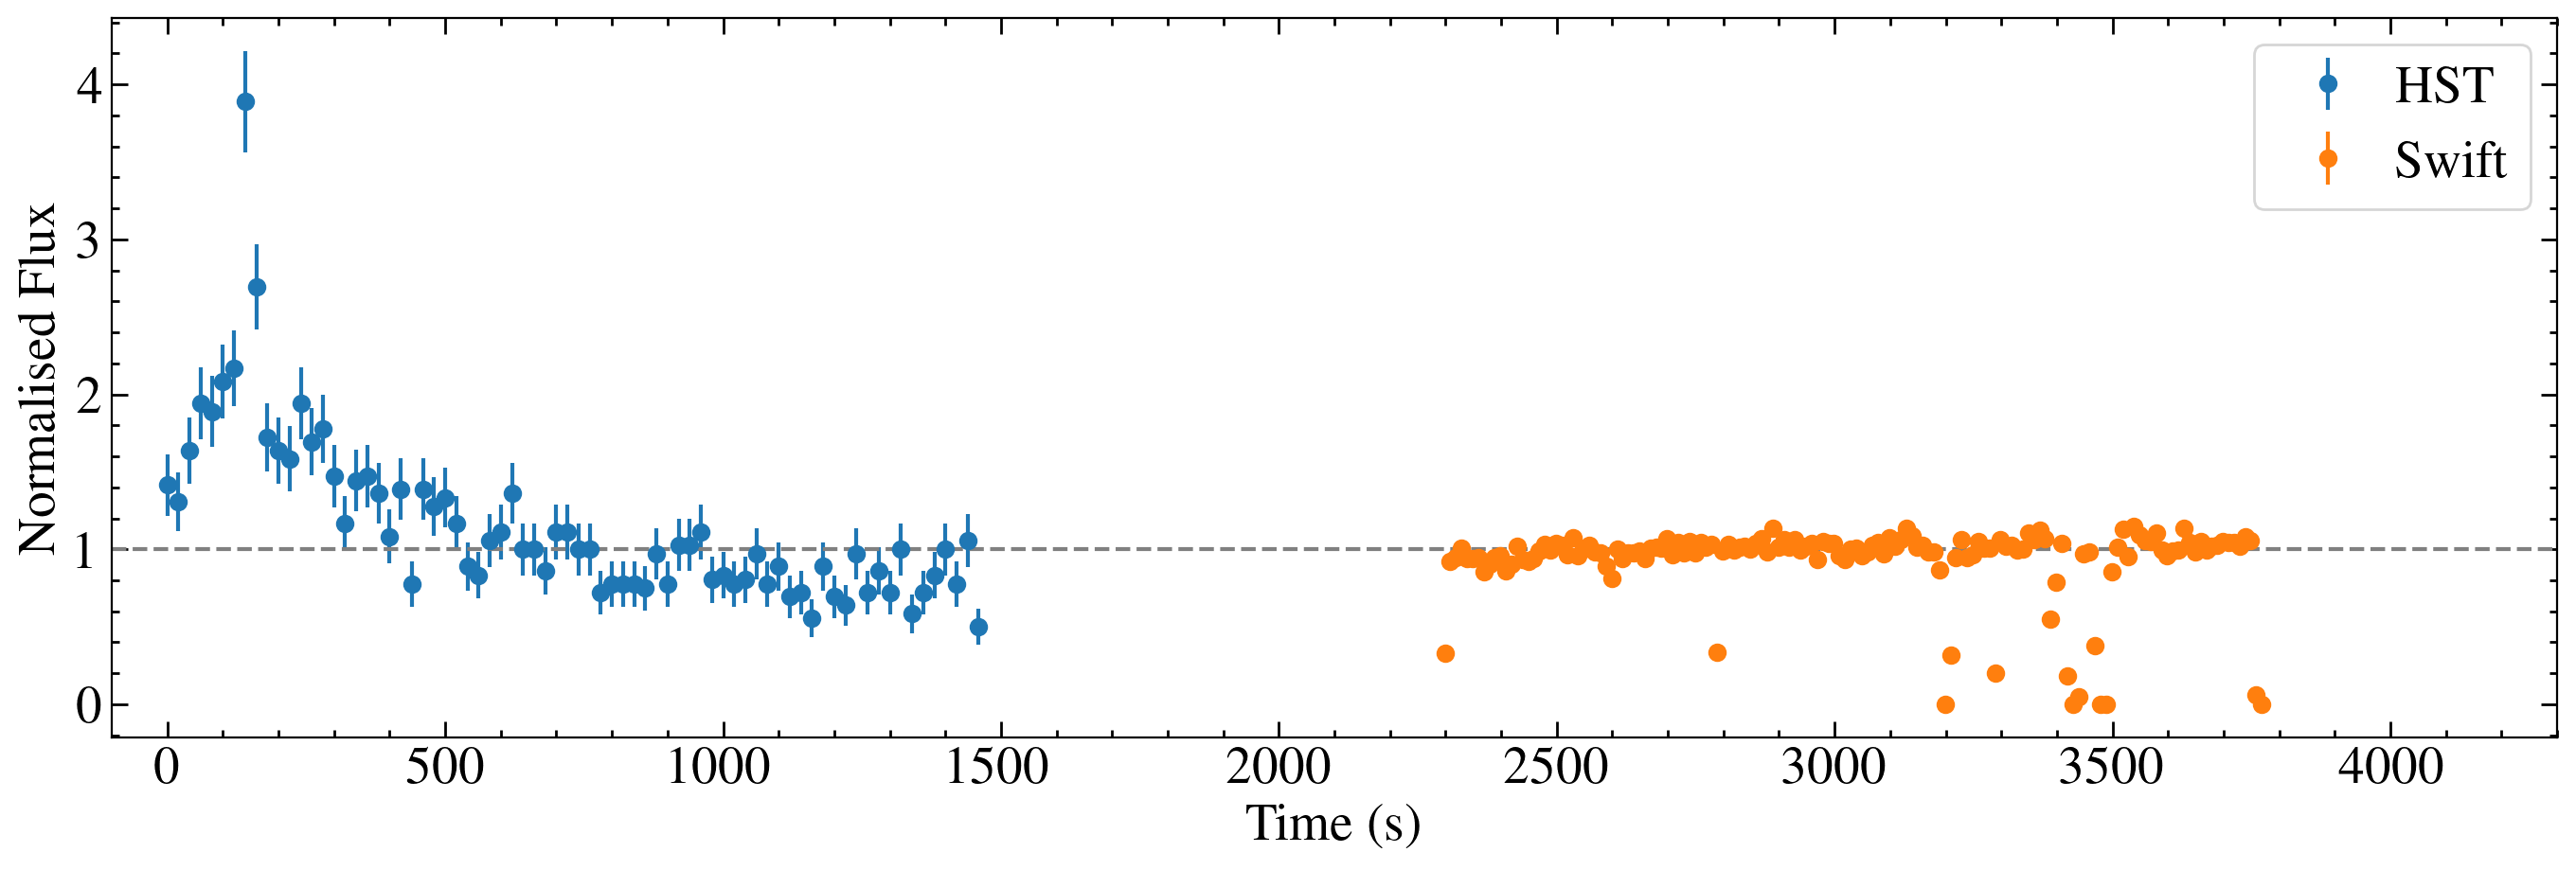

In [19]:
cos_start = 59580.796 #mjd
cos_lc = Table.read('cos_files/gj367/GJ367_COS130Mb_lightcurve.txt', format='ascii.basic')

norm = np.median(cos_lc['COUNTS'])
plt.errorbar(cos_lc['TIME'], cos_lc['COUNTS']/norm, yerr=cos_lc['ERROR']/norm, ls='none', marker='o', label='HST')

spath ='/media/david/2tb_ext_hd/hddata/meats/swift/gj367/working/'
swift_lcs = glob.glob('{}*u_10slc*.fits'.format(spath))

start_s = (cos_start-51910.00074287037)*86400

for lc in swift_lcs[1:]:
    data = fits.getdata(lc, 1)
    norm = np.median(data['AB_FLUX_AA'])
    print(data['TIME'][0])
    plt.errorbar(data['TIME']-start_s, data['AB_FLUX_AA']/norm, yerr= data['AB_FLUX_AA_ERR']/norm, ls='none', marker='o', label='Swift')
    
plt.xlim(-100, 4300)
plt.legend(frameon=True)

plt.axhline(1, ls='--', c='0.5')
plt.xlabel('Time (s)')
plt.ylabel('Normalised Flux')
plt.tight_layout()

In [21]:
xpath = '/media/david/2tb_ext_hd/hddata/meats/xmm/gj367/GJ367.fits'

In [22]:
hdul = fits.open(xpath)
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'GJ 367  '                                                            
HIERARCH Instrument = 'EPIC    '                                                

In [23]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48 / length of dimension 1                          
NAXIS2  =                   17 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   12 / number of table fields                         
TTYPE1  = 'Wave    '                                                            
TFORM1  = 'E       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'bin_width'                                                           
TFORM2  = 'E       '        

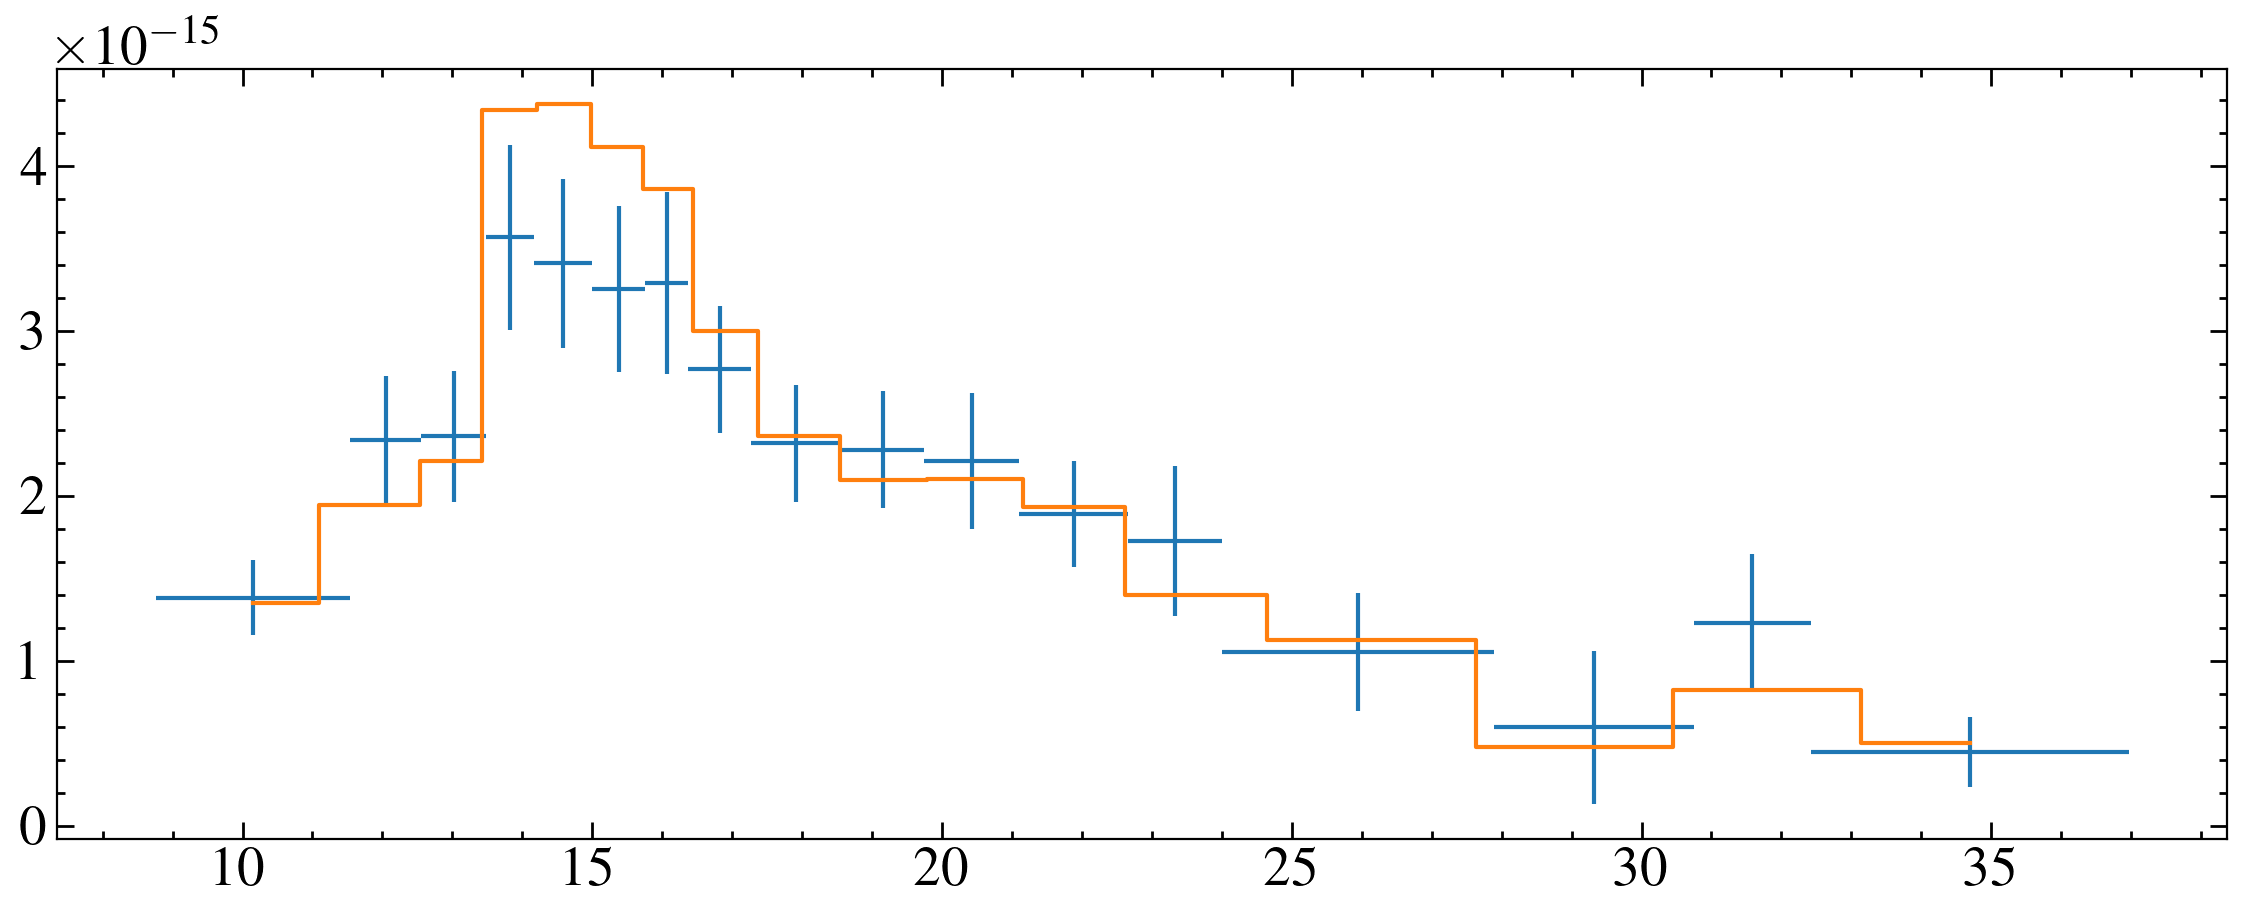

In [31]:
data = hdul[1].data
model= hdul[2].data
plt.errorbar(data['WAVE'], data['FLUX'], yerr=data['CFlux_err'], xerr=data['bin_width'], ls='none')
plt.step(data['WAVE'], data['MFlux'], where='mid')
# plt.plot(model['Wave'], model['Flux'], zorder=-1, alpha=0.7)

In [34]:
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'GJ 367  '                                                            
HIERARCH Instrument = 'EPIC    '                                                

In [35]:
hdr.append(('mos1_FILTER', 'Medium'))
hdr.append(('mos2_FILTER', 'Medium'))
hdr.append(('pn_FILTER', 'Medium'))
hdr.append(('pn_DURATION', 13000))
hdr.append(('pn_DATE-OBS', '2021-12-26 15:24:34'))
hdr.append(('pn_DATE-END','2021-12-26 19:01:14' ))
hdr.append(('OBS_ID', '0892000101'))
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'GJ 367  '                                                            
HIERARCH Instrument = 'EPIC    '                                                
HIERARCH mos1_FILTER = 'Medium  '                                               
HIERARCH mos2_FILTER = 'Medium  '                                               
HIERARCH pn_FILTER = 'Medium  '                                                 
HIERARCH pn_DURATION = 13000                                                    
HIERARCH pn_DATE-OBS = '2021-12-26 15:24:34'                                    
HIERARCH pn_DATE-END = '2021-12-26 19:01:14'                                    
OBS_ID  = '0892000101'      

In [37]:
hdul.writeto('/media/david/2tb_ext_hd/hddata/meats/xmm/gj367/GJ367_djw.fits', overwrite=True)

In [38]:
import prepare_xmm

xmm_path = '/media/david/2tb_ext_hd/hddata/meats/xmm/gj367/GJ367_djw.fits'

hlsp = dict(Table.read('meats_hlsp_info.csv'))
# hlsp = np.genfromtxt('meats_hlsp_info.csv', delimiter=',', dtype=None, names=True)
# xmm_path = xpath
version = 1

prepare_xmm.make_xmm_spectra(xmm_path, savepath, version, hlsp, apec_repo='models/', make_apec=True, save_ecsv=False, save_fits=True)

Spectrum saved as hlsp_muscles_xmm_epic_gj367_na_v1_component-spec.fits


Need to do APEC errors